## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import keras

2025-03-22 16:19:42.324173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742656782.399043   29565 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742656782.420678   29565 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 16:19:42.606776: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set all the Constants

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=150

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "output_data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7389 files belonging to 37 classes.


I0000 00:00:1742656787.897647   29565 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:26:00.0, compute capability: 8.6


In [4]:
class_names=dataset.class_names
class_names

['Abyssinian ',
 'Bengal ',
 'Birman ',
 'Bombay ',
 'British Shorthair ',
 'Egyptian Mau ',
 'Maine Coon ',
 'Persian ',
 'Ragdoll ',
 'Russian Blue ',
 'Siamese ',
 'Sphynx ',
 'american bulldog ',
 'american pit bull terrier ',
 'basset hound ',
 'beagle ',
 'boxer ',
 'chihuahua ',
 'english cocker spaniel ',
 'english setter ',
 'german shorthaired ',
 'great pyrenees ',
 'havanese ',
 'japanese chin ',
 'keeshond ',
 'leonberger ',
 'miniature pinscher ',
 'newfoundland ',
 'pomeranian ',
 'pug ',
 'saint bernard ',
 'samoyed ',
 'scottish terrier ',
 'shiba inu ',
 'staffordshire bull terrier ',
 'wheaten terrier ',
 'yorkshire terrier ']

In [5]:
len(class_names)

37

In [6]:
len(dataset)

462

2025-03-22 16:19:49.539203: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


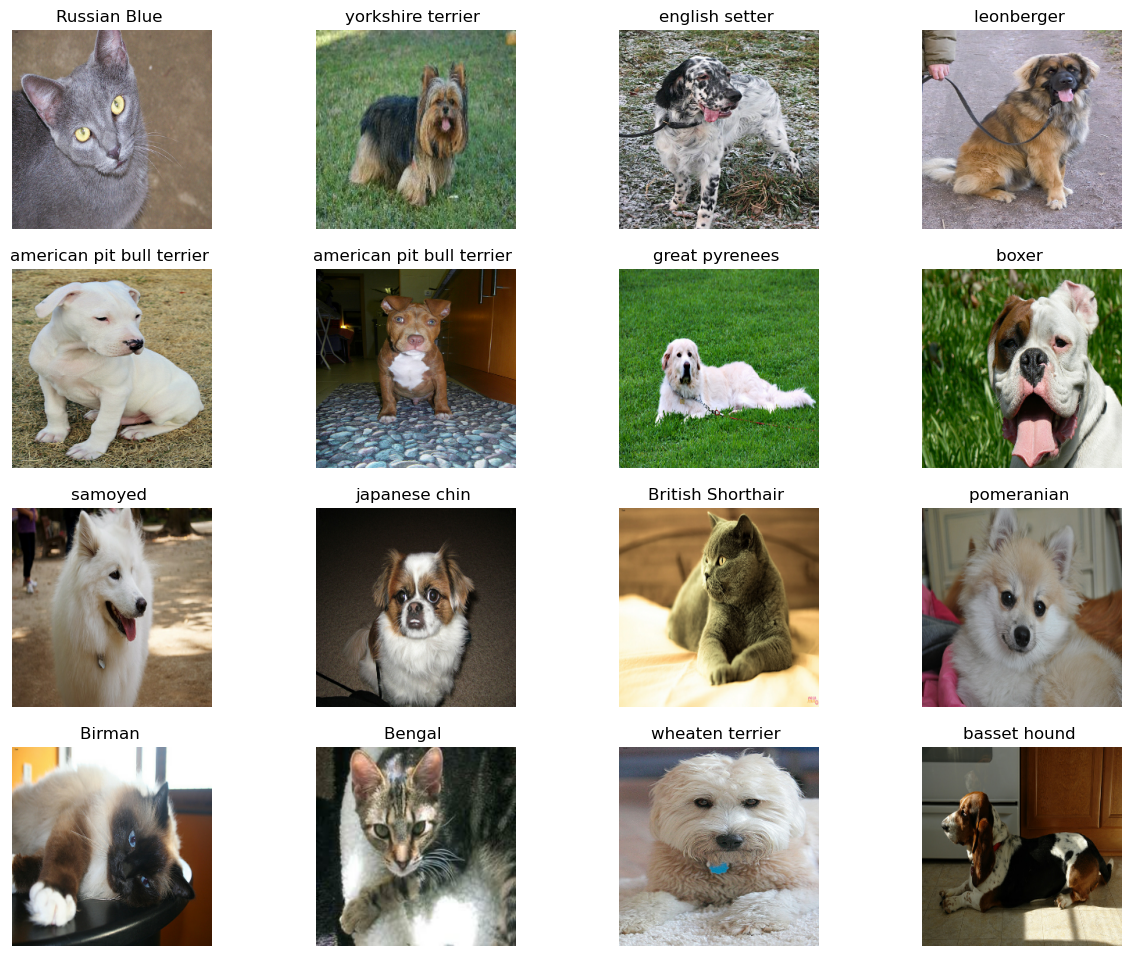

In [7]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
    for i in range(16):
        plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

## Split Dataset

In [8]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10_000):
    assert (train_split+val_split+test_split==1)

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=42)

    train_size = int(train_split*ds_size)
    valid_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

369

In [11]:
len(val_ds)

46

In [12]:
len(test_ds)

47

## Cache, Shuffle, and Prefetch the Dataset

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255)
])

### Data Augmentation

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15)
])

### Applying Data Augmentation to Train Dataset

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

In [17]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 37

In [18]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    resize_and_rescale,
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(0.1),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((3, 3)),
    layers.Dropout(0.1),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer='he_normal'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu',kernel_initializer='he_normal'),
    layers.Dense(n_classes, activation='softmax')
])

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 84, 84, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84, 84, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 82, 82, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         4,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 511,941 (1.95 MB)

 Trainable params: 511,941 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=150)

Epoch 1/150


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
I0000 00:00:1742656799.148420   29660 service.cc:148] XLA service 0x7f75ec00e4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742656799.148814   29660 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-22 16:19:59.199922: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742656799.450156   29660 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/369 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.0556 - loss: 4.6544   

I0000 00:00:1742656804.417219   29660 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0343 - loss: 3.6827  

2025-03-22 16:20:33.412610: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 8589934592 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1742656833.413150   29898 device_host_allocator.h:61] could not allocate pinned host memory of size: 8589934592
2025-03-22 16:20:33.413218: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1253] failed to alloc 7730940928 bytes on host: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
W0000 00:00:1742656833.413296   29898 device_host_allocator.h:61] could not allocate pinned host memory of size: 7730940928
2025-03-22 16:20:43.227986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 307 of 10000
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2025-03-22 16:20:44.014144: I tensorflow/core/kernels/data/shuffle_dataset_o

369/369 ━━━━━━━━━━━━━━━━━━━━ 58s 121ms/step - accuracy: 0.0343 - loss: 3.6825 - val_accuracy: 0.0625 - val_loss: 3.5304
Epoch 2/150
369/369 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.0712 - loss: 3.4504 - val_accuracy: 0.1209 - val_loss: 3.2216
Epoch 3/150
369/369 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.1017 - loss: 3.2534 - val_accuracy: 0.1427 - val_loss: 3.1036
Epoch 4/150
369/369 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.1299 - loss: 3.1167 - val_accuracy: 0.1508 - val_loss: 2.9533
Epoch 5/150
369/369 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.1552 - loss: 3.0049 - val_accuracy: 0.1997 - val_loss: 2.8681
Epoch 6/150
369/369 ━━━━━━━━━━━━━━━━━━━━ 29s 77ms/step - accuracy: 0.1795 - loss: 2.8887 - val_accuracy: 0.2269 - val_loss: 2.6548
Epoch 7/150
369/369 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.2046 - loss: 2.7890 - val_accuracy: 0.2609 - val_loss: 2.6437
Epoch 8/150
369/369 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.2309 - loss: 2.6800 - val

In [22]:
scores = model.evaluate(test_ds)
scores

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7066 - loss: 1.2448


[1.269183874130249, 0.6994680762290955]

### Plotting the Accuracy and Loss Curves

In [23]:
history.params

{'verbose': 1, 'epochs': 150, 'steps': 369}

In [24]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

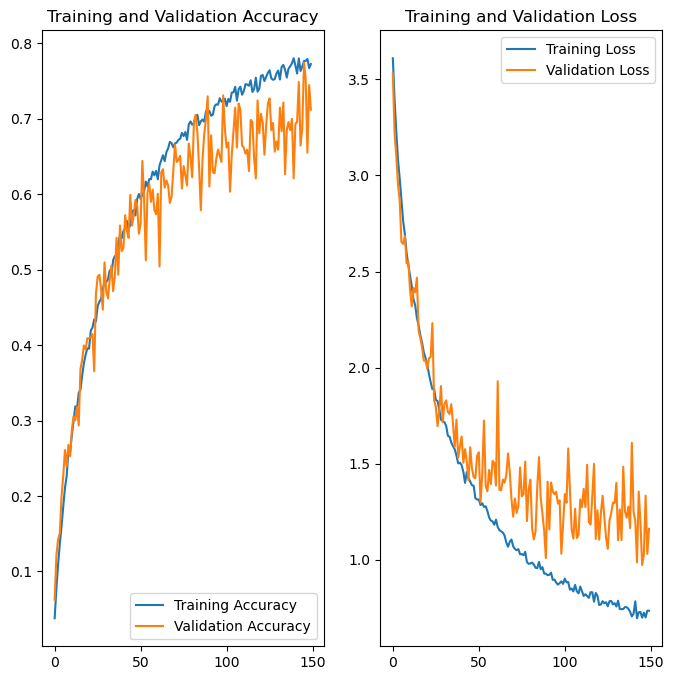

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(150), acc, label='Training Accuracy')
plt.plot(range(150), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(150), loss, label='Training Loss')
plt.plot(range(150), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label:  British Shorthair 
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label:  British Shorthair 


2025-03-22 17:49:09.550303: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


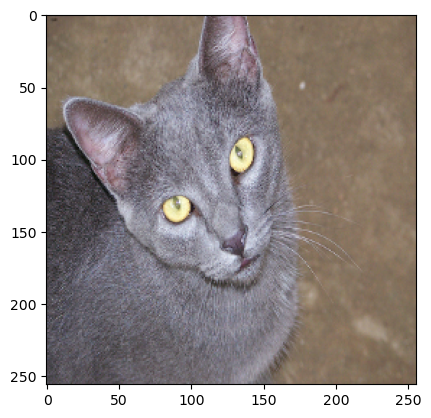

In [27]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])

    batch_pred = model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_pred[0])])

## Function for inference

In [28]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    preds = model.predict(img_array)
    pred_class = class_names[np.argmax(preds[0])]
    confidence = round(100* (np.max(preds[0])),2)
    return pred_class,confidence

## Run inference on few sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


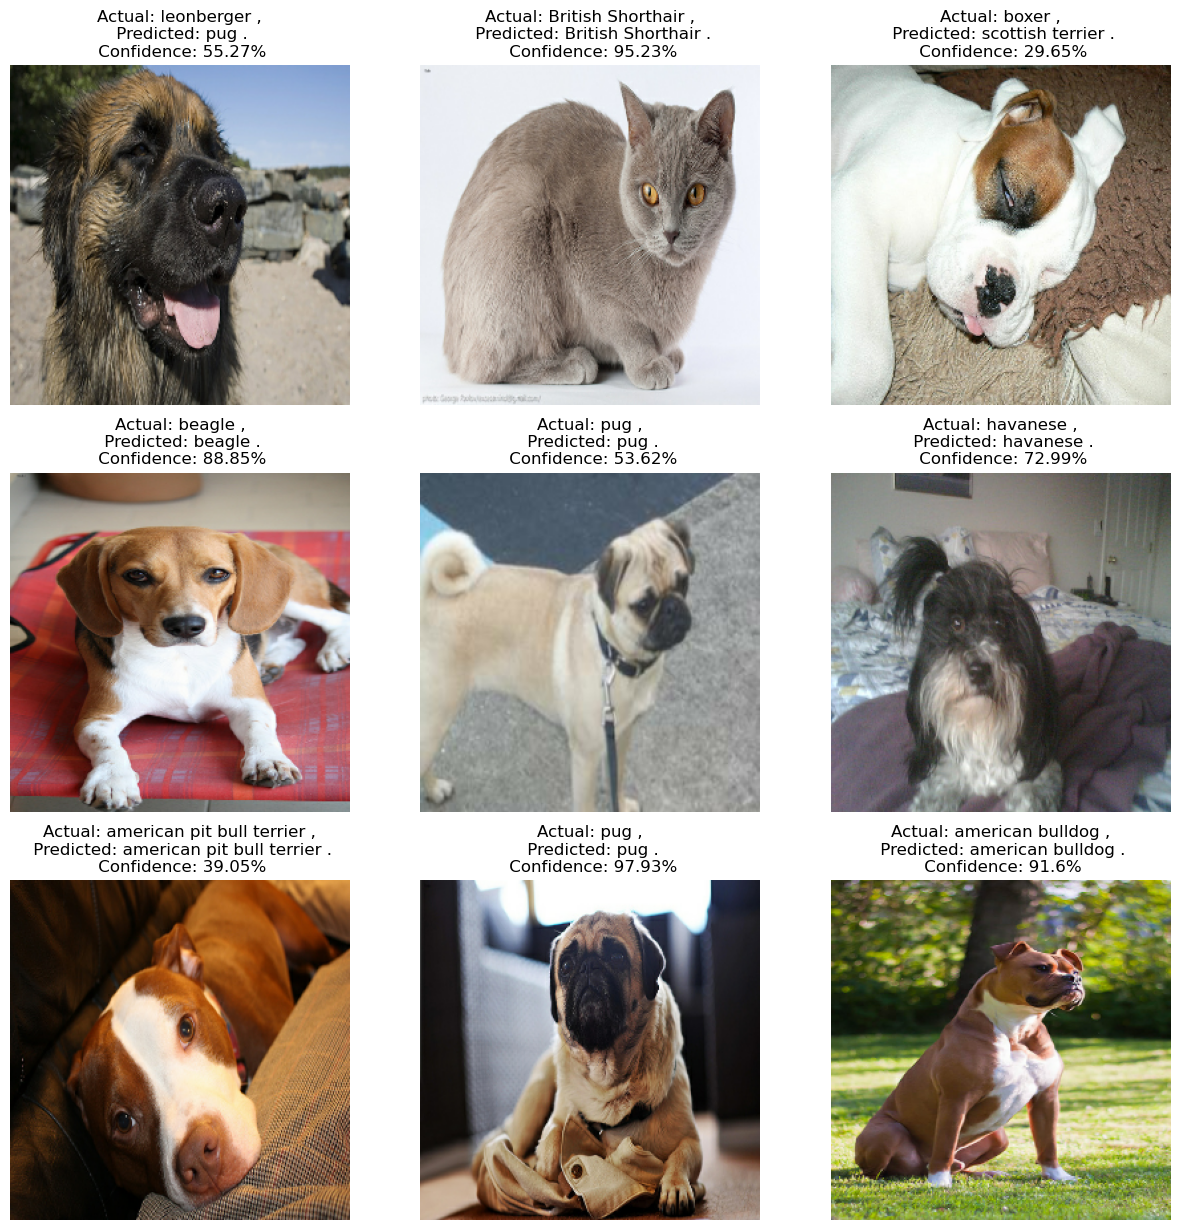

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [30]:
import os
model_version = max([int(i.split(".")[0]) for i in os.listdir("../model") if i.split(".")[0].isdigit()] + [0]) + 1
model.save(f"../model/{model_version}.keras")


In [31]:
model.save(f"../model/{model_version}.h5")

In [8]:
from tensorflow.keras.models import load_model
import tensorflow as tf
model = load_model('8.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open('breed_classifier_optimized.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp382fy0ju/assets


INFO:tensorflow:Assets written to: /tmp/tmp382fy0ju/assets


Saved artifact at '/tmp/tmp382fy0ju'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 37), dtype=tf.float32, name=None)
Captures:
  140340367904080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340367901264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340936271824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340401884144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340368865056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340368863648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340369516672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340369120240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340404842336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340404841984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140340971949

W0000 00:00:1742670955.947681    3215 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1742670955.947708    3215 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-22 20:15:55.947822: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp382fy0ju
2025-03-22 20:15:55.948271: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-22 20:15:55.948278: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp382fy0ju
2025-03-22 20:15:55.952494: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-22 20:15:55.978774: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp382fy0ju
2025-03-22 20:15:55.986573: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 38752 microseconds.


524152